# 차량 EV 경진대회

## Data Import

In [1]:
import pandas as pd
import os 

train = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/CarEV/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/CarEV/test.csv')
submit = pd.read_csv('https://raw.githubusercontent.com/han942/vscode/refs/heads/main/datafile/dacon/CarEV/sample_submission.csv')

In [2]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [3]:
test.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0


In [4]:
submit.head()

,ID,가격(백만원)
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


In [5]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes,columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) *100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ
summary(train)

data shape: (7497, 11)


,data type,#missing,%missing,#unique,min,max
ID,object,0,0.000000,7497,NaN,NaN
제조사,object,0,0.000000,7,NaN,NaN
모델,object,0,0.000000,21,NaN,NaN
차량상태,object,0,0.000000,3,NaN,NaN
배터리용량,float64,2711,36.161131,194,46.0,99.8
구동방식,object,0,0.000000,3,NaN,NaN
주행거리(km),int64,0,0.000000,6916,3.0,199827.0
보증기간(년),int64,0,0.000000,11,0.0,10.0
사고이력,object,0,0.000000,2,NaN,NaN
연식(년),int64,0,0.000000,3,0.0,2.0


In [6]:
cat_col = []
bin_col = []
con_col = []

for i in train.columns:
    if train[i].nunique() > 21 :
        con_col.append(i)
    elif (train[i].nunique() <= 21) & (train[i].nunique() > 2):
        cat_col.append(i)
    else:
        bin_col.append(i)
        
print('범주형 변수: ',cat_col)
print('이산형 변수: ',bin_col)
print('연속형 변수: ',con_col)

범주형 변수:  ['제조사', '모델', '차량상태', '구동방식', '보증기간(년)', '연식(년)']
이산형 변수:  ['사고이력']
연속형 변수:  ['ID', '배터리용량', '주행거리(km)', '가격(백만원)']


"한글을 인식하지 못할 상황을 대비한 전처리"


In [7]:
test['제조사'] = test['제조사'].apply(lambda x: x.replace('사',''))
train['제조사'] = train['제조사'].apply(lambda x: x.replace('사',''))
train.head()

train['배터리용량'] = train['배터리용량'].fillna(train['배터리용량'].mean())
train.isna().sum()

test['배터리용량'] = test['배터리용량'].fillna(test['배터리용량'].mean())
test.isna().sum()

ID          0
제조사         0
모델          0
차량상태        0
배터리용량       0
구동방식        0
주행거리(km)    0
보증기간(년)     0
사고이력        0
연식(년)       0
dtype: int64

## EDA

In [8]:
df_c = train.copy()
df_c.drop('ID',axis=1,inplace=True)
df_c.head()

,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,P,TayGTS,Nearly New,86.077000,AWD,13642,0,No,2,159.66
1,K,Niro,Nearly New,56.000000,FWD,10199,6,No,0,28.01
2,A,eT,Brand New,91.200000,AWD,2361,7,No,0,66.27
3,A,RSeTGT,Nearly New,69.397187,AWD,21683,3,No,0,99.16
4,B,i5,Pre-Owned,61.018000,AWD,178205,1,No,0,62.02


In [9]:
con_col.remove('ID')

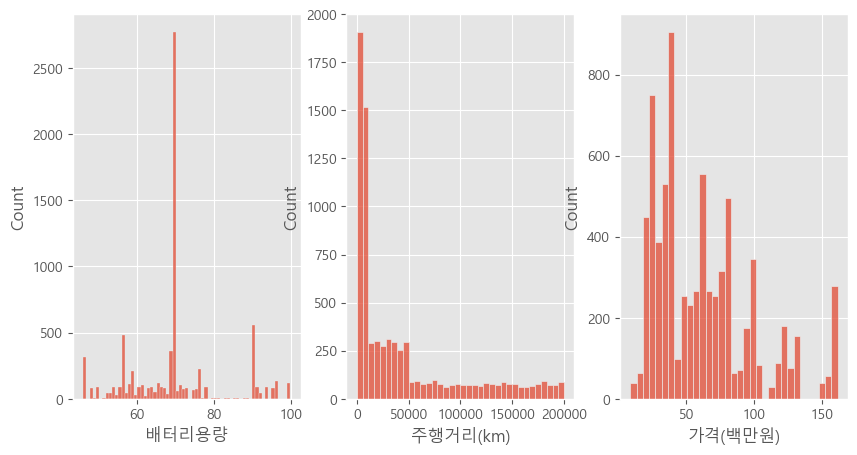

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use('ggplot')

# 각 Feature의 분포도 plot
fig,ax = plt.subplots(1,3,figsize=(10,5))
ax = ax.flatten()

for i,col in enumerate(con_col):
    sns.histplot(df_c[col],ax=ax[i])

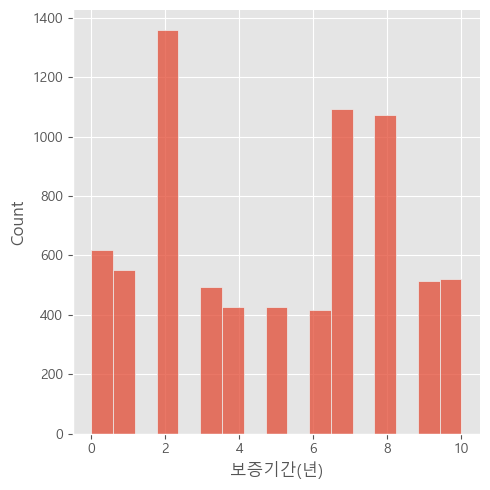

In [11]:
sns.displot(df_c['보증기간(년)'])

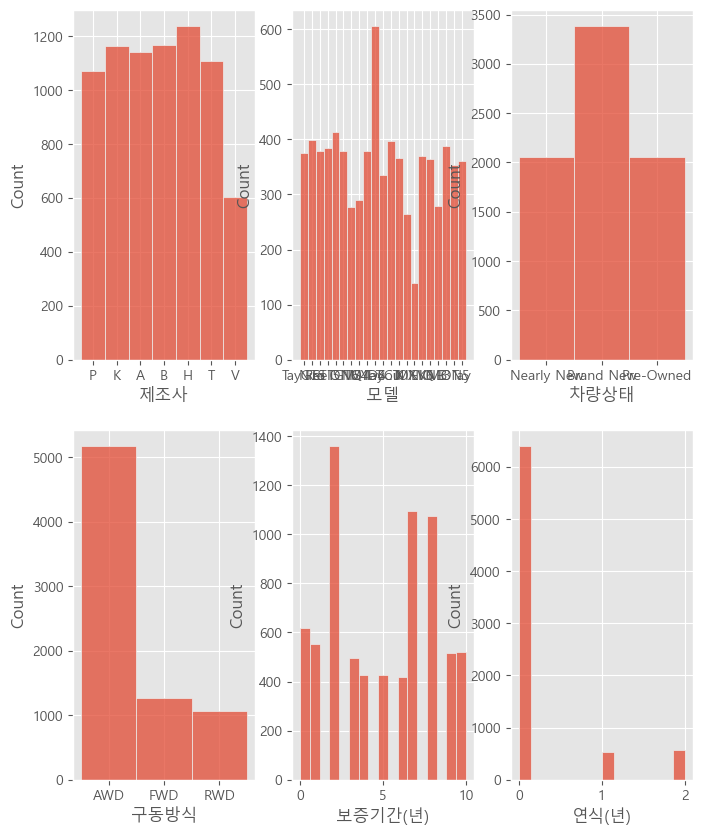

In [12]:
#범주형 변수의 분포
fig,ax = plt.subplots(2,3,figsize=(8,10))
ax = ax.flatten()
for i,col in enumerate(cat_col):
    sns.histplot(x=df_c[col],ax=ax[i])

### 0. 종속변수(가격)
- skewness:1
결측치 X

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


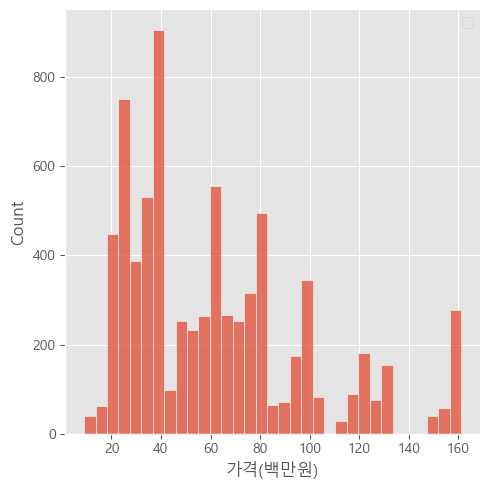

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use('ggplot')

sns.displot(train['가격(백만원)'])
plt.legend(loc='best')

In [14]:
train.columns

Index(['ID', '제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', '보증기간(년)',
       '사고이력', '연식(년)', '가격(백만원)'],
      dtype='object')

### 1. 제조사
- 각 제조사별 (7개)의 도수가 비슷함
- P 제조사가 가장 차량의 가격이 높다.

<Axes: xlabel='제조사', ylabel='가격(백만원)'>

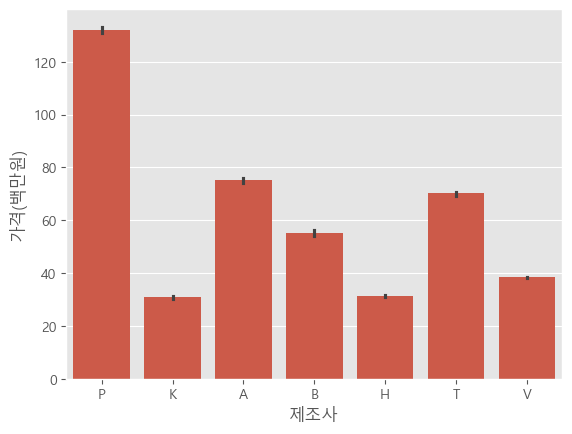

In [15]:
sns.barplot(y=train['가격(백만원)'],x=train['제조사'])

### 2. 모델
- 대체로 분포 균일
- 'TayGTS'모델의 값이 가장 높으며, IonicQ의 모델 가격이 가장 낮음



In [16]:
train['모델'].unique()

array(['TayGTS', 'Niro', 'eT', 'RSeTGT', 'i5', 'ION6', 'MS', 'MY', 'Q4eT',
       'ID4', 'TayCT', 'Soul', 'iX', 'MX', 'IONIQ', 'EV6', 'KNE', 'M3',
       'i3', 'ION5', 'Tay'], dtype=object)

<Axes: ylabel='가격(백만원)'>

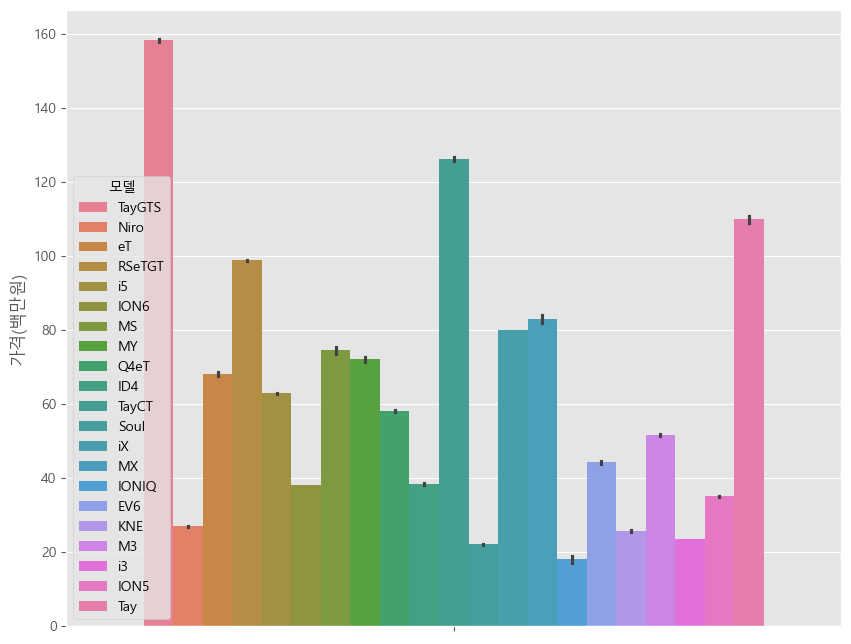

In [17]:
plt.figure(figsize=(10,8))
sns.barplot(y=train['가격(백만원)'],hue=train['모델'])

### 3. 차량상태
- 분포도 비슷하고, 차량상태에따른 가격 변동차이도 거의 없음.

<Axes: ylabel='가격(백만원)'>

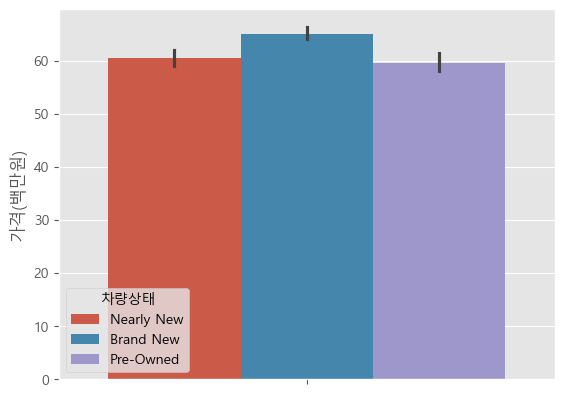

In [18]:
sns.barplot(y=train['가격(백만원)'],hue=train['차량상태'])

### 4. 배터리용량 
- 용량이 69.397187인 도수가 가장 많은 부분을 차지.
- 대체로 배터리용량이 증가할 수록 가격도 상승하는 상관관계

<Axes: xlabel='배터리용량', ylabel='가격(백만원)'>

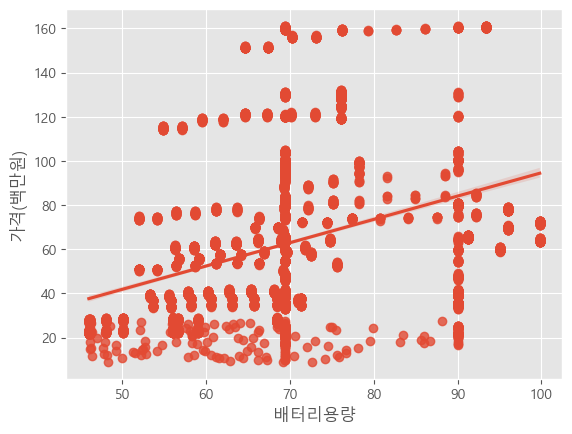

In [19]:
sns.regplot(y=train['가격(백만원)'],x=train['배터리용량'])

In [20]:
train.columns

Index(['ID', '제조사', '모델', '차량상태', '배터리용량', '구동방식', '주행거리(km)', '보증기간(년)',
       '사고이력', '연식(년)', '가격(백만원)'],
      dtype='object')

### 5. 구동방식
- 분포에는 크게 차이는 없다. AWD의 가격이 많이 높다

<Axes: ylabel='가격(백만원)'>

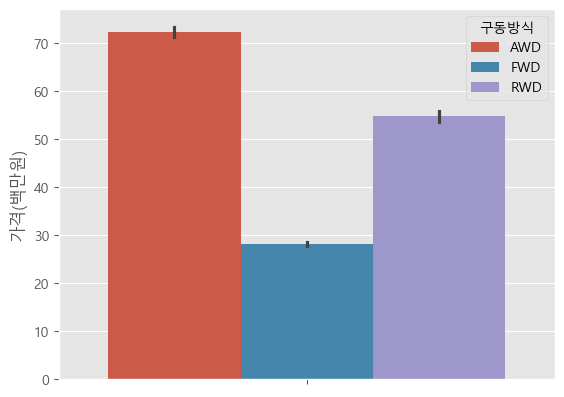

In [21]:
sns.barplot(y=train['가격(백만원)'],hue=train['구동방식'])

## Feature Engineering
- 종속변수에 가장 상관관계 -> 배터리용량 / 보증기간

In [22]:
df_c = train.copy()
df_c.drop('ID',axis=1,inplace=True)

df1_c = test.copy()
df1_c.drop('ID',axis=1,inplace=True)
df_c.corr(numeric_only=True)

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.493106,0.402651,-0.019862,0.351512
주행거리(km),-0.493106,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.402651,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.019862,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.351512,-0.035488,-0.349962,-0.058455,1.000000


In [23]:
df_c.dtypes

제조사          object
모델           object
차량상태         object
배터리용량       float64
구동방식         object
주행거리(km)      int64
보증기간(년)       int64
사고이력         object
연식(년)         int64
가격(백만원)     float64
dtype: object

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_c[cat_col] = df_c[cat_col].apply(lambda x: le.fit_transform(x))
df1_c[cat_col] = df1_c[cat_col].apply(lambda x: le.fit_transform(x))

df_c['사고이력']  = le.fit_transform(df_c['사고이력'])
df1_c['사고이력']  = le.fit_transform(df1_c['사고이력'])

## 모델 탐색

##### XGBRegressor

- 아무 전처리 없이(평균값) : 1.5323

In [25]:
from optuna import Trial,visualization
from optuna.samplers import TPESampler
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error


def objectivexgr(trial:Trial,X,y):
    param = {'n_estimators':500,
             'learning_rate':0.2543520418820113,
             'max_depth':trial.suggest_int('max_depth',4,10),
             'min_child_weight':trial.suggest_int('min_child_weight',3,10),
             'random_state':42} 
    model = XGBRegressor(**param)
    xgb_model = model.fit(X,y,verbose=False)
    answer = xgb_model.predict(X)
    score = root_mean_squared_error(y,answer)

    return score

c:\Anaconda3\envs\vscode_jupyter\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=2024))

study.optimize(lambda trial: objectivexgr(trial,df_c.drop(columns=['가격(백만원)']),df_c['가격(백만원)']),n_trials=10)
print('Best trial: score {}, \nparmas {}'.format(study.best_trial.value,study.best_trial.params))

[I 2025-01-07 21:36:41,998] A new study created in memory with name: no-name-56824833-a079-46f6-8d59-d2a7dc2c2858
[I 2025-01-07 21:36:42,431] Trial 0 finished with value: 0.684850185813672 and parameters: {'max_depth': 8, 'min_child_weight': 8}. Best is trial 0 with value: 0.684850185813672.
[I 2025-01-07 21:36:42,721] Trial 1 finished with value: 0.7592021842830223 and parameters: {'max_depth': 5, 'min_child_weight': 3}. Best is trial 0 with value: 0.684850185813672.
[I 2025-01-07 21:36:43,020] Trial 2 finished with value: 0.7592021842830223 and parameters: {'max_depth': 5, 'min_child_weight': 3}. Best is trial 0 with value: 0.684850185813672.
[I 2025-01-07 21:36:43,514] Trial 3 finished with value: 0.6540706894784374 and parameters: {'max_depth': 9, 'min_child_weight': 8}. Best is trial 3 with value: 0.6540706894784374.
[I 2025-01-07 21:36:43,915] Trial 4 finished with value: 0.6849986388609448 and parameters: {'max_depth': 7, 'min_child_weight': 6}. Best is trial 3 with value: 0.654

Best trial: score 0.6444149097445402, 
parmas {'max_depth': 7, 'min_child_weight': 4}


In [27]:
optuna.visualization.plot_optimization_history(study)

In [34]:
df_c.shape,df1_c.shape
X,y = df_c.drop(columns=['가격(백만원)']),df_c['가격(백만원)']
X_test = df1_c

In [36]:
X_test.dtypes

제조사           int32
모델            int32
차량상태          int32
배터리용량       float64
구동방식          int32
주행거리(km)      int64
보증기간(년)       int64
사고이력          int32
연식(년)         int64
dtype: object

In [45]:
import numpy as np
from sklearn.model_selection import KFold
folds = KFold(n_splits=5,shuffle=True,random_state=2025)

test_preds = np.zeros(len(X_test))
val_scores = []

for idx,(train_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'Fold {idx+1} / Fold {folds.n_splits}')
    X_train,y_train = X.iloc[train_idx],y.iloc[train_idx]
    X_val,y_val = X.iloc[val_idx],y.iloc[val_idx]

    xgb_model = XGBRegressor(**study.best_params)

    xgb_model.fit(X_train,y_train)

    train_y_pred = xgb_model.predict(X_train)
    val_y_pred = xgb_model.predict(X_val)

    print(f'Train RMSE: {root_mean_squared_error(y_train,train_y_pred)}')
    print(f'Val RMSE: {root_mean_squared_error(y_val,val_y_pred)}')

    test_preds += xgb_model.predict(X_test) / folds.n_splits
    y_preds = xgb_model.predict(X_val)
    val_scores.append(root_mean_squared_error(y_val,y_preds))

print(f'RMSE: {np.array(val_scores).mean()}')

Fold 1 / Fold 5
Train RMSE: 0.7945527249884695
Val RMSE: 1.3589767776403523
Fold 2 / Fold 5
Train RMSE: 0.7854376498562028
Val RMSE: 1.5502803880170435
Fold 3 / Fold 5
Train RMSE: 0.7691842048967013
Val RMSE: 1.6963886793943086
Fold 4 / Fold 5
Train RMSE: 0.7712032097035613
Val RMSE: 1.5372344852129745
Fold 5 / Fold 5
Train RMSE: 0.769615995799593
Val RMSE: 1.4736130037936819
RMSE: 1.5232986668116721


## 결과물 제출